In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

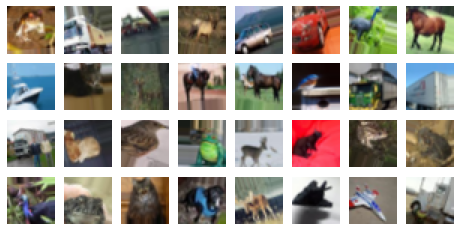

In [5]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(x_train[:32], shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

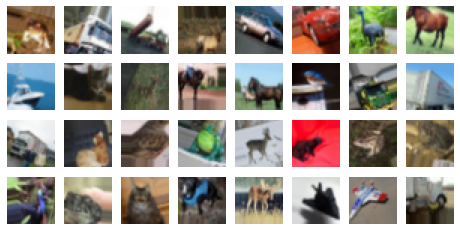

In [6]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(x_train[:32], shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [7]:
# 利用ImageDataGenerator進行資料擴增
# 自訂義data_aug(images,labels,aug_times) 三個參數分別為輸入圖片, 標籤, 增量倍數(int, 1=增量1倍)

def data_aug(images,labels,aug_times):

  augmented_images = images 
  augmented_labels = labels 

  data_generator = ImageDataGenerator(
    
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

  if aug_times >= 1:
    for i in range(aug_times):
      batch_aug_img = next(data_generator.flow(images, shuffle=False, batch_size=len(images)))
      augmented_images = np.concatenate((augmented_images, batch_aug_img))
      augmented_labels = np.concatenate((augmented_labels, augmented_labels))

  else:
    print('error! arg* aug_times should >= 1')

  return augmented_images, augmented_labels


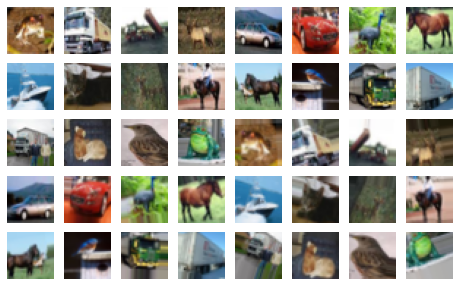

(40, 1)
[[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
 [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]]


In [8]:
# 取前20張測試 def data_aug() 是否正常發揮
x, y = data_aug(x_train[:20], y_train[:20], 1) 
img_combine(x.astype('int'))
print(y.shape)
print(y.T.reshape(2,-1))

In [9]:
# 資料擴增完才進行標準化等動作
print('----before aug----')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


# 圖片增量一倍
x_train, y_train = data_aug(x_train, y_train, 1)

print('----after aug----')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

----before aug----
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
----after aug----
x_train shape: (100000, 32, 32, 3)
100000 train samples
10000 test samples


In [10]:
def create_model(num_classes=10):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same',
                  input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(Conv2D(16, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  model.summary()
  return model

In [11]:
# 超參數設定
BATCH_SIZE = 256
EPOCHS = 50

In [12]:
# model training withput data augmentation
(x_train2, y_train2), (x_test2, y_test2) = cifar10.load_data()
x_train2 = x_train2.astype('float32')
x_test2 = x_test2.astype('float32')
x_train2 /= 255
x_test2 /= 255

# Convert class vectors to binary class matrices.
y_train2 = keras.utils.to_categorical(y_train2, 10)
y_test2 = keras.utils.to_categorical(y_test2, 10)

model = create_model()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.fit(x_train2, y_train2,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test2, y_test2))




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        4

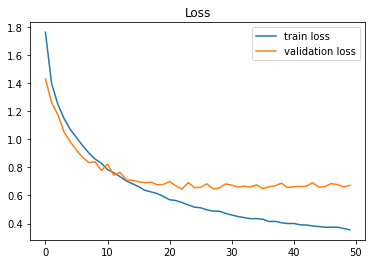

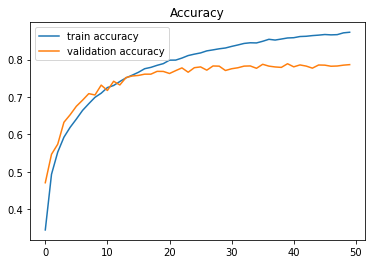

In [13]:
plt.plot(range(len(model.history.history["loss"])),model.history.history["loss"], label='train loss')
plt.plot(range(len(model.history.history["val_loss"])),model.history.history["val_loss"], label='validation loss')

plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(model.history.history["accuracy"])),model.history.history["accuracy"], label='train accuracy')
plt.plot(range(len(model.history.history["val_accuracy"])),model.history.history["val_accuracy"], label='validation accuracy')

plt.legend()
plt.title("Accuracy")
plt.show()

In [14]:
# model training with data augmentation (double the amount of training data)
model2 = create_model()
model2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model2.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, y_test))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 16)        2320      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 32)       

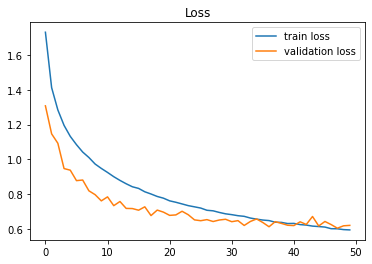

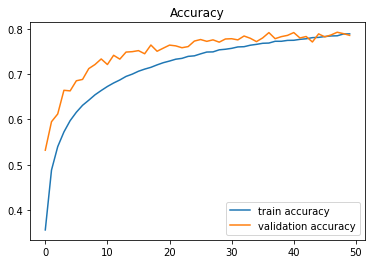

In [15]:
plt.plot(range(len(model2.history.history["loss"])),model2.history.history["loss"], label='train loss')
plt.plot(range(len(model2.history.history["val_loss"])),model2.history.history["val_loss"], label='validation loss')

plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(model2.history.history["accuracy"])),model2.history.history["accuracy"], label='train accuracy')
plt.plot(range(len(model2.history.history["val_accuracy"])),model2.history.history["val_accuracy"], label='validation accuracy')

plt.legend()
plt.title("Accuracy")
plt.show()